In [19]:
pip install tensorflow


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import zscore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso


מודל KNN להשלמת ניתונים חסרים

In [21]:
def preprocessing(data):
    knn_imputer = KNNImputer(n_neighbors=5)
    numeric_cols = data.select_dtypes(include=['number']).columns
    data[numeric_cols] = knn_imputer.fit_transform(data[numeric_cols])
    return data

Standard Deviation

In [22]:
def scaling(X_train, X_test):
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  return X_train_scaled,X_test_scaled

In [23]:
def scaling_nerual(X_train, X_test):
  scaler = RobustScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  return X_train_scaled,X_test_scaled

הצגת מדדי איכות המודל


In [24]:
# הצגת מדדי איכות
def print_metrics(y_true, y_pred, model_name):
    print(f"\n Evaluation Metrics for {model_name}:")
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R²   :", r2_score(y_true, y_pred))


הצגת ניתונים BOXPLOT

In [25]:
def boxplot(df,feature_names):
  sns.boxplot(x=feature_names)
  plt.xticks(rotation=45)
  plt.show()

**הצגת** Residual Plot

In [26]:
def plot_residuals(y_true, y_pred, model_name="Model"):
  residuals = y_true - y_pred
  plt.figure(figsize=(8, 5))
  sns.scatterplot(x=y_pred, y=residuals)
  plt.axhline(0, color='red', linestyle='--')
  plt.title(f"Residual Plot - {model_name}")
  plt.xlabel("Predicted Values")
  plt.ylabel("Residuals")
  plt.grid(True)
  plt.show()

רגרסיה לינארית

In [27]:

# מודל רגרסיה ליניארית
def run_linear_regression(X_train, X_test, y_train, y_test,feature_names):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_
    })
    coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)
    print(coef_df)
    print_metrics(y_test, y_pred, "Linear Regression")

מודל עצי החלטה עם GridSearchCV

In [28]:
def run_decision_tree(X_train, X_test, y_train, y_test):
    # בניית המודל
    model = DecisionTreeRegressor(max_depth=8, random_state=42,min_samples_leaf=5,min_samples_split=4,)

    # טווח ערכים להיפר-פרמטרים
    param_grid = {
        'max_depth': [3, 5, 8, 10, None],
        'min_samples_split': [2, 4, 6, 10],
        'min_samples_leaf': [1, 2, 5, 10]
    }

    # הגדרת GridSearchCV עם 5 קפלים
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    # הרצה על הסט של האימון
    grid_search.fit(X_train, y_train)


    # הרצה על הסט של האימון
    grid_search.fit(X_train, y_train)
    # שימוש במודל הטוב ביותר
    best_model = grid_search.best_estimator_

    # חיזוי
    y_pred = best_model.predict(X_test)



    # הדפסת מדדי ביצוע
    print_metrics(y_test, y_pred, "Decision Tree Regressor")

    # Residual Plot
    plot_residuals(y_test, y_pred, model_name="Decision Tree Regressor")

RANDOM FOREST ללא GridSearchCV

In [29]:
def run_random_forest_without_GRCV(X_train, X_test, y_train, y_test,feature_names):


 model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42
)
 model.fit(X_train, y_train)
 y_pred = model.predict(X_test)
 print_metrics(y_test, y_pred, "Random Forest")
 importances_rf = model.feature_importances_

# יצירת טבלה
 rf_feature_importance = pd.Series(importances_rf, index=feature_names).sort_values(ascending=True)

# הצגה גרפית
 rf_feature_importance.plot(kind='barh', title="Feature Importance - Random Forest")
 plt.xlabel("Importance")
 plt.show()


RANDOM FOREST עם GridSearchCV

In [30]:
# מודל Random Forest
def run_random_forest(X_train, X_test, y_train, y_test,feature_names):


  param_grid = {
        'n_estimators': [100, 200, 300],     # מספר עצים
        'max_depth': [None, 10, 20, 30],     # עומק מקסימלי
        'min_samples_split': [2, 5, 10],     # מינימום דוגמאות לפיצול
        'min_samples_leaf': [1, 2, 4]        # מינימום דוגמאות לעלה
    }

  grid_search = GridSearchCV(
  estimator=RandomForestRegressor(random_state=42),
  param_grid=param_grid
  )

    # אימון
  grid_search.fit(X_train, y_train)

    # שליפת המודל הטוב ביותר
  best_model = grid_search.best_estimator_

    # חיזוי
  y_pred = best_model.predict(X_test)

# שליפת המודל הטוב ביותר
  best_model = grid_search.best_estimator_

    # חיזוי
  y_pred = best_model.predict(X_test)

  # מדדי הערכה
  print_metrics(y_test, y_pred, "Random Forest")
  plot_residuals(y_test, y_pred, model_name="Random Forest")


  return best_model, y_pred

XGBRegressor

In [31]:
def run_xgboost(X_train, X_test, y_train, y_test,feature_names):
    # הגדרת המודל
    #model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model=XGBRegressor(n_estimators=300, max_depth=10, learning_rate=0.1,  random_state=42)

    # אימון
    model.fit(X_train, y_train)

    # חיזוי
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    # מדדים
    print_metrics(y_test, y_pred, "XGBRegressor")

    plot_residuals(y_test, y_pred, model_name="XGBRegressor")

    importances_xgb = model.feature_importances_

# טבלה
    xgb_feature_importance = pd.Series(importances_xgb, index=feature_names).sort_values(ascending=True)

# גרף
    xgb_feature_importance.plot(kind='barh', title="Feature Importance - XGBoost")
    plt.xlabel("Importance")
    plt.show()

רשת נוירונים עם GridSearchCV

In [32]:
def run_neural_network_WITH_GRCV(X_train, X_test, y_train, y_test):
  param_grid = {
        'hidden_layer_sizes': [
    (16,), (32,), (64,),
    (32,16), (64,32),
    (64,64)],
        'activation': ['relu'],                           # פונקציית הפעלה
        'early_stopping': [True],
        'alpha': [0.0001, 0.001, 0.01],                           # רגולריזציה
        'learning_rate_init': [0.001, 0.01]                       # קצב למידה
    }

    # הגדרת GridSearchCV
  grid_search = GridSearchCV(
        estimator=MLPRegressor(max_iter=600, random_state=42),
        param_grid=param_grid,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )

    # אימון
  grid_search.fit(X_train, y_train)

    # שליפת המודל הטוב ביותר
  best_model = grid_search.best_estimator_

    # חיזוי
  y_pred = best_model.predict(X_test)

    # מדדי הערכה
  print("Best Parameters:", grid_search.best_params_)
  print_metrics(y_test, y_pred, "Neural Network with GridSearchCV ")

  plot_residuals(y_test, y_pred, model_name="Neural Network")
  return best_model, y_pred

רשת נוירונים

In [33]:
def run_neural_network(X_train, X_test, y_train, y_test):


  model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),

    Dense(1)
  ])

    # כאן השורה צריכה להיות מוזחת כמו כל שאר השורות בפונקציה
  model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # אימון המודל
  model.fit(X_train , y_train, epochs=200, batch_size=32, verbose=0)

    # חיזוי

  y_pred = model.predict(X_test).flatten()

  residuals = y_test - y_pred


    # מדדים
  print_metrics(y_test, y_pred, "Neural Network")
  plot_residuals(y_test, y_pred, model_name="Neural Network")

In [34]:
def featuresInfo(df):
  results = []
  for col in df.select_dtypes(include=[np.number]).columns:
    x = df[col]

    # סטיית תקן
    std_dev = np.std(x)

    # זיהוי Outliers לפי Z-Score
    z_scores = zscore(x)
    z_outliers = np.abs(z_scores) > 3
    z_count = np.sum(z_outliers)
    z_percent = (z_count / len(x)) * 100

    # זיהוי Outliers לפי IQR
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    iqr_outliers = (x < lower) | (x > upper)
    iqr_count = np.sum(iqr_outliers)
    iqr_percent = (iqr_count / len(x)) * 100

    # הוספה לרשימה
    results.append({
        'Feature': col,
        'Std_Dev': round(std_dev, 3),
        'Z_Outliers': z_count,
        'Z_%': round(z_percent, 2),
        'IQR_Outliers': iqr_count,
        'IQR_%': round(iqr_percent, 2)
    })

# המרה לטבלה
  summary_df = pd.DataFrame(results)
# הצגה
  print(summary_df)
  return summary_df




הפעלה המודלים

In [35]:
def run(X_train, X_test, y_train, y_test,feature_names):
 run_linear_regression(X_train, X_test, y_train, y_test,feature_names)
 run_random_forest(X_train, X_test, y_train, y_test,feature_names)
 run_decision_tree(X_train, X_test, y_train, y_test)
 run_xgboost(X_train, X_test, y_train, y_test,feature_names)
 run_neural_network(X_train, X_test, y_train, y_test)


In [36]:
def lasso(X_train,X_test,y_train,y_test):
  lasso = Lasso(alpha=0.1)
  lasso.fit(X_train, y_train)

  # תחזיות והערכת מודל
  y_pred = lasso.predict(X_test)
  print("R²:", r2_score(y_test, y_pred))

cliping ניתונים לרשת נוירונים לטיפול בחריגות


In [37]:
def cliping(X,summary_df):

# סף חריגות באחוזים
  threshold = 8

# עותק של הדאטה לעיבוד
  df_clipped = X.copy()

# בחירת העמודות הרלוונטיות (שמספר החריגים בהן גבוה מ־7%)
  features_to_clip = summary_df[summary_df['IQR_%'] > threshold]['Feature'].tolist()

  for col in features_to_clip:
    Q1 = df_clipped[col].quantile(0.25)
    Q3 = df_clipped[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # ביצוע Clipping לערכים קיצוניים
    df_clipped[col] = df_clipped[col].clip(lower, upper)

  print("בוצע Clipping לעמודות:", features_to_clip)

           Feature  Coefficient
2            trees     1.425777
1     city_heights     0.985247
3  cars_per_person     0.736933
0      numberofpop    -0.327570
4   bus_per_person    -0.288723

 Evaluation Metrics for Linear Regression:
MAE : 4.283690280798872
RMSE: 5.424284281366905
R²   : 0.08351349123950913

 Evaluation Metrics for Random Forest:
MAE : 2.6335357872008442
RMSE: 3.809517979870145
R²   : 0.5479554404414434


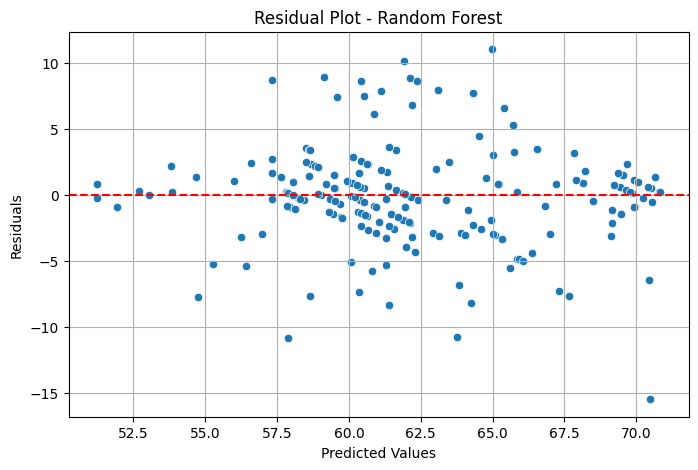

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits

 Evaluation Metrics for Decision Tree Regressor:
MAE : 2.893748248360276
RMSE: 4.195534778306326
R²   : 0.45170303440686366


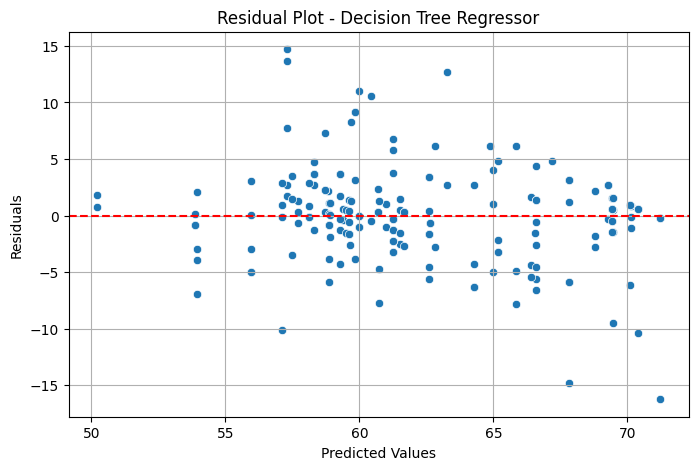


 Evaluation Metrics for XGBRegressor:
MAE : 2.7170188426971436
RMSE: 4.033851198310654
R²   : 0.4931482672691345


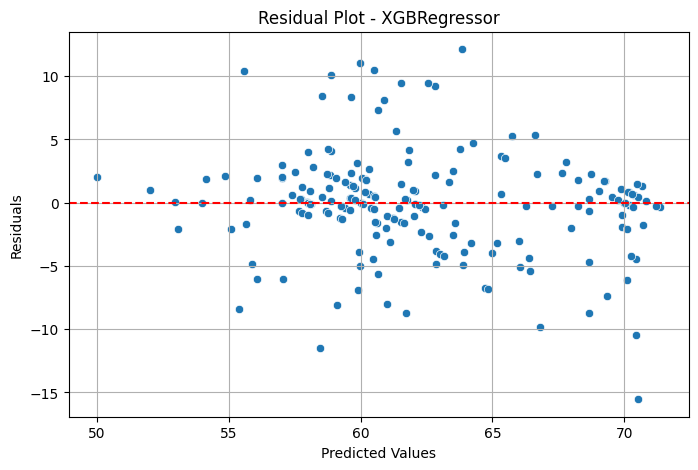

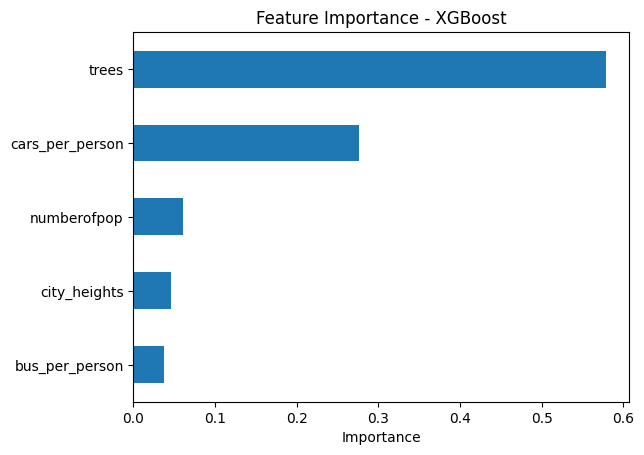

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

 Evaluation Metrics for Neural Network:
MAE : 4.214884281158447
RMSE: 5.382129110907643
R²   : 0.09770315885543823


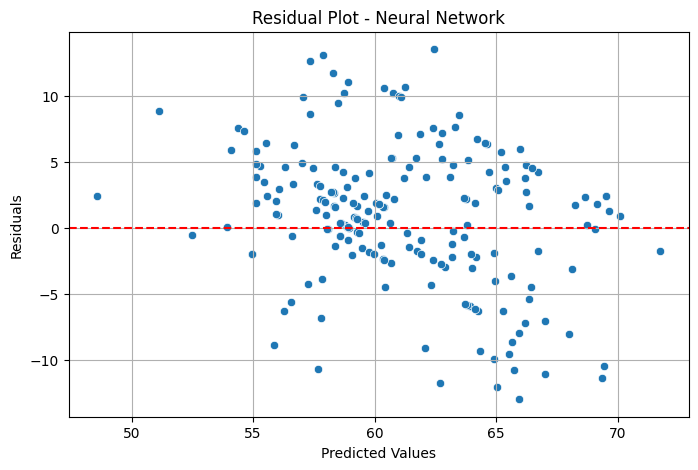

In [38]:

# MAIN – הרצה
def main():

    file_path ="/content/newdatajsonfortest.csv"


    # קריאת הקובץ
    df = pd.read_csv(file_path)
    df["cars_per_person"] = df["cars"] / (df["numberofpop"] )* 1000
    df["bus_per_person"] = df["busStations"] / (df["numberofpop"])* 1000

    # הפרדת מאפיינים (X) ועמודת מטרה (y)
    X = df.drop(columns=['hebname','lat','lan','aqi_global','cars','busStations','pol_fact','amount_of_pol','num_fact','type','belogns'])
    target_column = "aqi_global"
    feature_names =X.columns.tolist()
    y = df[target_column]
    #x_nueral=X.drop(columns=['num_pol_fact','amount_of_pol'])
    x_nueral=X


    X=preprocessing(X)
    x_nueral=preprocessing(x_nueral)
    y_neural=y
   # print (x_nueral)

    # BOXPLOT עבור הפיצרים לבחינתם
    #boxplot(X,feature_names)
    # סטיית תקן ועוד עבור הפיצרים לבחינתם
   # summary_df=featuresInfo(X)
    #cliping(X,summary_df)

    X['numberofpop'] = np.log1p(X['numberofpop'])


    x_nueral['trees'] = np.log1p(x_nueral['trees'])
    x_nueral['numberofpop'] = np.log1p(x_nueral['numberofpop'])

    #x_nueral['num_fact'] = (x_nueral['num_fact'] > 0).astype(int)
    #sns.histplot(df['city_heights'], kde=True)
    #sns.heatmap(X.corr(), annot=True, cmap='coolwarm')

    #summary_df=featuresInfo(x_nueral)



        # פיצול לסט אימון ובדיקה
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_scale,X_test_scale=scaling( X_train,X_test)

    X_train_neural, X_test_neural, y_train_neural, y_test_neural = train_test_split(x_nueral, y_neural, test_size=0.2, random_state=42)
    X_train_neural, X_test_neural=scaling_nerual( X_train_neural, X_test_neural)


    # הרצת המודלים
    run(X_train_scale, X_test_scale, y_train, y_test,feature_names)

    #run_neural_network(X_train_neural, X_test_neural, y_train_neural, y_test_neural)



# הפעלת הקוד
main()
